# Steps to prepare the environment

- Create a conda env (see [Development Environment](https://fasrc.github.io/pycausalgps/setup_env_dev.html#setting-up-a-new-environment))
- Install pycausalgps

In [ ]:
# Useful resources:
# - https://blog.dask.org/2017/03/28/dask-xgboost 

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from pycausalgps.gps_utils import generate_syn_pop
from scipy.stats import norm
from scipy import stats
from sklearn.neighbors import KernelDensity
from dask_ml.model_selection import train_test_split


In [2]:
# Generate synthetic data

data_obj = generate_syn_pop(10000)
df = data_obj.data
df

,Y,treat,cf1,cf2,cf3,cf4,cf5,cf6
0,-126.953607,0.766875,-0.401620,0.850582,-0.392851,0.419767,-2,-0.597141
1,14.050169,13.903410,-1.861099,-0.032390,0.646664,-0.187456,0,2.482473
2,20.018614,18.056160,0.464031,-0.517499,-0.748986,0.048788,0,1.086488
3,-5.230470,12.899953,-1.225908,0.139312,1.812821,-0.425485,1,2.690245
4,-2.293533,14.531439,0.640696,0.480784,-0.564486,1.166049,2,-1.362021
...,...,...,...,...,...,...,...,...
9995,-28.611572,6.368574,-1.292575,0.098783,-0.202847,0.306125,-1,-2.160731
9996,-18.683464,11.360968,1.718792,-1.708646,0.690987,2.180764,-1,-0.910518
9997,8.507415,12.011994,0.785421,-0.345016,-0.386282,1.191992,1,0.458402
9998,-115.108589,0.531398,0.516291,-1.257521,1.145106,-1.528612,-1,1.817267


## Workflow

- Step 1: Set up Dask client
   
   - This part requires some research to find the best combination. We want the users to be able to choose different schedulers without dealing with internal details.  
       
- Step 2: Load data
   
   - You need to load data into a dask data.frame directly. If you reading from a csv or any other physical file, dask can support it. In this example, I just generate the psuedo population and then convert it into dask dataframe. [TODO: see if it is necessary to generate a dask data frame directly.]
            
- Step 3: Data preprocessing and cleaning
   
    - This step also should happen on a dask dataframe to speed up the process.
    - Cleaning data includes:
        - Handling missing values
        - Handling column names (replace space with _)
        - Sanity check all columns (see the unique values)
        - Hotencoding
    
- Step 4: Hyper parameters and user defined parameters
   
   - percentage of data used for training
   - objective function       
   
- Step 5: Generate training and test data

     
- Step 6: Estimate GPS Value (parametric)
    
    - Estimate treatment (w) from counfonders --> e_gps
    - Compute standard deviation of (w - e_gps) --> e_gps_std
    - Compute normal distributeion of each value given mean (e_gps) and standard deviation (e_gps_std) --> gps
    
- Step 7: Estimate GPS Value (non-parametric)

    - Estimate treatment (w) from counfonders --> e_gps
    - Estimate standard deviation (abs(w-e_gps)) from confounders --> e_gps_std
    - Estimate residuals (w - g_gps)/(e_gps_std) --> w_resid
    - Compute gps from density --> gps
        - compute kernel density based on residuals (w_resid), drop na values.
        - approximate (interpolate) corrosponding kernel density for each residual value. 
    

In [3]:
# Step 1

import dask.dataframe as dd
from dask.distributed import Client

# local cluster
from dask.distributed import LocalCluster

# parameters
n_workers = 4

cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)
client

/Users/nak443/anaconda3/envs/pycgps_dev/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65393 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65393/status,
Dashboard: http://127.0.0.1:65393/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65394,Workers: 4
Dashboard: http://127.0.0.1:65393/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:65407,Total threads: 3
Dashboard: http://127.0.0.1:65412/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:65397,


In [4]:
# Step 2

# parameters
npartitions=4

ddf = dd.from_pandas(df, npartitions=npartitions)
ddf

,Y,treat,cf1,cf2,cf3,cf4,cf5,cf6
npartitions=4,,,,,,,,
0,float64,float64,float64,float64,float64,float64,int64,float64
2500,...,...,...,...,...,...,...,...
5000,...,...,...,...,...,...,...,...
7500,...,...,...,...,...,...,...,...
9999,...,...,...,...,...,...,...,...


In [12]:
# Step 3

# This step needs more attention in real data. For now, I just categorize cf5.
# Remember One-hot encoding is not good for linear and logestic regression
from dask_ml.preprocessing import DummyEncoder

# make cf5 category
ddf = ddf.categorize(columns=["cf5"])
dm = DummyEncoder()
ddf_enc = dm.fit_transform(ddf)
ddf_enc.head()

,Y,treat,cf1,cf2,cf3,cf4,cf6,cf5_-2,cf5_0,cf5_1,cf5_2,cf5_-1
0,-126.953607,0.766875,-0.401620,0.850582,-0.392851,0.419767,-0.597141,1,0,0,0,0
1,14.050169,13.903410,-1.861099,-0.032390,0.646664,-0.187456,2.482473,0,1,0,0,0
2,20.018614,18.056160,0.464031,-0.517499,-0.748986,0.048788,1.086488,0,1,0,0,0
3,-5.230470,12.899953,-1.225908,0.139312,1.812821,-0.425485,2.690245,0,0,1,0,0
4,-2.293533,14.531439,0.640696,0.480784,-0.564486,1.166049,-1.362021,0,0,0,1,0


In [9]:
# Step 4

# percent of training data

tr_pr = 0.8
parametric = True


In [ ]:
print(f'Length of training data: {len(X_train)} which is {(len(X_train)/len(X))*100} percent of original data.')
print(f'Length of training data: {len(X_test)} which is {(len(X_test)/len(X))*100} percent of original data.')

[0]	train-rmse:52.45153
[1]	train-rmse:47.46127
[2]	train-rmse:44.31671
[3]	train-rmse:42.41135
[4]	train-rmse:41.25538
[5]	train-rmse:40.31435
[6]	train-rmse:39.55109
[7]	train-rmse:39.14244
[8]	train-rmse:38.64381
[9]	train-rmse:38.26784
[10]	train-rmse:38.11453
[11]	train-rmse:37.73249
[12]	train-rmse:37.38663
[13]	train-rmse:37.24048
[14]	train-rmse:36.79621
[15]	train-rmse:36.52591
[16]	train-rmse:36.14262
[17]	train-rmse:35.86876
[18]	train-rmse:35.54476
[19]	train-rmse:35.35802


[12:50:01] task [xgboost.dask]:tcp://127.0.0.1:65408 got new rank 0
[12:50:01] task [xgboost.dask]:tcp://127.0.0.1:65407 got new rank 1
[12:50:01] task [xgboost.dask]:tcp://127.0.0.1:65405 got new rank 2
[12:50:01] task [xgboost.dask]:tcp://127.0.0.1:65406 got new rank 3
[12:50:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for distributed training.
[12:50:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for distributed training.
[12:50:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for distributed training.
[12:50:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for di

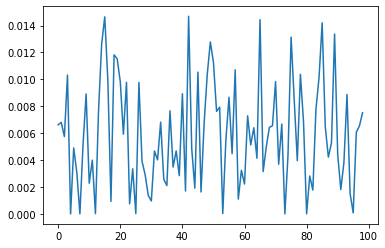

In [14]:
# Step 6

if parametric:
    X = ddf_enc.drop(["Y", "treat"], axis=1).copy()
    y = ddf_enc["Y"].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= tr_pr,
                                                        random_state=123, shuffle=True)
    dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
    dall_data = xgb.dask.DaskDMatrix(client, X, y)
    output = xgb.dask.train(
        client, 
        {"verbosity":2, "objective":"reg:squarederror"},
        dtrain,
        num_boost_round=20,
        evals=[(dtrain, "train")]
    )
    # predict gps value for all data
    e_gps = xgb.dask.predict(client, output, dall_data)
    e_gps_tmp = (e_gps - ddf_enc["treat"])
    e_gps_obj = e_gps_tmp.std()
    e_gps_std = e_gps_obj.compute()
    gps = norm.pdf(ddf_enc["treat"], e_gps, e_gps_std)
    plt.plot(gps[1:100])

In [ ]:
# Step 7 

if not parametric:
    X = ddf_enc.drop(["Y", "treat"], axis=1).copy()
    y = ddf_enc["Y"].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= tr_pr,
                                                        random_state=123, shuffle=True)
    dtrain1 = xgb.dask.DaskDMatrix(client, X_train, y_train)
    dall_data_1 = xgb.dask.DaskDMatrix(client, X, y)
    output1 = xgb.dask.train(
        client, 
        {"verbosity":2, "objective":"reg:squarederror"},
        dtrain1,
        num_boost_round=20,
        evals=[(dtrain1, "train")],
    )
    # predict gps value for all data
    e_gps = xgb.dask.predict(client, output1, dall_data_1)
    
    y2 = (y - e_gps).abs()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, train_size= tr_pr,
                                                       random_state=123, shuffle=True)
    dtrain_2 = xgb.dask.DaskDMatrix(client, X_train_2, y_train_2)
    dall_data_2 = xgb.dask.DaskDMatrix(client, X, y2)
    output_2 = xgb.dask.train(
        client, 
        {"verbosity":2, "objective":"reg:squarederror"},
        dtrain_2,
        num_boost_round=4,
        evals=[(dtrain_2, "train")],
    )
    # predict standard deviation of gps value for all data
    e_gps_std = xgb.dask.predict(client, output_2, dall_data_2)
    
    # compute residual
    w_resid = (y - e_gps)/e_gps_std
    
    # compute kernel density estimate ("gaussain")
    kernel = stats.gaussian_kde(w_resid)
    gps = kernel(w_resid)
    
